Importing libraries

In [261]:
import pandas as pd

Reading the csv file

In [262]:
df = pd.read_csv('hepsiemlak.csv')

Data cleaning

In [263]:
print(f'Before: {df['loc'].iloc[0]}\tAfter: {df['loc'].iloc[0].split()[-2]}')
df['loc'] = df['loc'].apply(lambda x: x.split()[-2])

Before: İzmir / Buca / Menderes Mah.	After: Menderes


In [264]:
print(f'Before: {df['price'].iloc[0]}\tAfter: {df['price'].iloc[0].replace('.', '')}')
df['price'] = df['price'].str.replace('.', '').astype(int)

Before: 20.000	After: 20000


In [265]:
print(f'Before: {df['gross'].iloc[0]}\tAfter: {df['gross'].iloc[0].split()[0]}')
df['gross'] = df['gross'].str.split().str[0].astype(int)

Before: 130 m²	After: 130


In [266]:
print(f'Before:\t\t\tAfter:\nrooms: {df['rooms'].iloc[0]}\t\trooms: {df['rooms'].iloc[0].split('+')[0]} Salons: {df['rooms'].iloc[0].split('+')[1]}\n\nUniques before: {df['rooms'].unique()}\n\nUniques after: {df['rooms'].str.replace('Stüdyo', '1 + 0').unique()}')

df.loc[df['rooms'] == 'Stüdyo', 'rooms'] = '1 + 0'
df['salons'] = df['rooms'].str.split('+').str[1].astype(int)
df['rooms'] = df['rooms'].str.split('+').str[0].astype(int)

Before:			After:
rooms: 4 + 1		rooms: 4  Salons:  1

Uniques before: ['4 + 1' '1 + 1' 'Stüdyo' '2 + 1' '3 + 1' '2 + 0' '1 + 2' '11 + 18'
 '3 + 11' '2 + 2']

Uniques after: ['4 + 1' '1 + 1' '1 + 0' '2 + 1' '3 + 1' '2 + 0' '1 + 2' '11 + 18'
 '3 + 11' '2 + 2']


In [267]:
print(f'Before: {df['age'].iloc[0]}\tAfter: {df['age'].iloc[0].replace('Sıfır', '0').split()[0]}')
df['age'] = df['age'].str.replace('Sıfır', '0').str.split().str[0].astype(int)

Before: 25 Yaşında	After: 25


In [268]:
temp = df['floor'].unique()
df['floor'] = df['floor'].replace('Giriş Katı', 0.0)
df['floor'] = df['floor'].replace('Ara Kat', 0.5)
df['floor'] = df['floor'].replace('En Üst Kat', 15.0)
df['floor'] = df['floor'].replace('Yüksek Giriş', 0.75)
df['floor'] = df['floor'].replace('Yarı Bodrum', -0.5)
df['floor'] = df['floor'].replace('Zemin', 0.0)
df['floor'] = df['floor'].replace('Kot 1', 1.0)
df['floor'] = df['floor'].replace('Kot 2', 2.0)
df['floor'] = df['floor'].replace('Çatı Katı', 15.0)
df['floor'] = df['floor'].replace('Bahçe Katı', 0.25)
df['floor'] = df['floor'].replace('Teras Katı', 20.0)
df['floor'] = df['floor'].fillna(-1)

temp1 = df['floor'].str.contains('. Kat')
df.loc[temp1 == True, 'floor'] = df.loc[temp1 == True, 'floor'].str[0]
df['floor'] = df['floor'].astype(float)

print(f'Before: {temp}\n\nAfter: {df['floor'].unique()}')

Before: ['2. Kat' 'Ara Kat' 'En Üst Kat' '4. Kat' '12. Kat' 'Yüksek Giriş'
 '3. Kat' '1. Kat' nan 'Yarı Bodrum' '10. Kat' 'Zemin' '5. Kat' 'Kot 1'
 'Giriş Katı' 'Çatı Katı' 'Bahçe Katı' 'Kot 2' '6. Kat' '7. Kat' '8. Kat'
 'Teras Katı' '9. Kat']

After: [ 2.    0.5  15.    4.    1.    0.75  3.   -1.   -0.5   0.    5.    0.25
  6.    7.    8.   20.    9.  ]


Calculating the number of days the house listing has been active.

In [269]:
df['date'] = pd.to_datetime(df['date'], format = '%d-%m-%Y')
df['days'] = (pd.Timestamp.now() - df['date']).dt.days

Separating the dependent variable from the independent variables

In [270]:
X = pd.get_dummies(df.drop(columns = ['price', 'date', 'ad']))
y = df['price']

Doing simple regression using cross-validation

In [271]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
lgbm = LGBMRegressor(verbose = -1, learning_rate = 0.01, eval_metric = 'r2')

cross_val_score(lgbm, X, y, cv = 10, scoring = 'r2').mean()

np.float64(-1.8558114953948661)

Preparing data for plotting

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_style('darkgrid')

df.drop(columns = 'ad', inplace = True)
df = df.reindex(columns=['price', 'category', 'gross', 'rooms', 'salons', 'age', 'floor', 'days', 'loc', 'date'])

Plots that shows correlation between the features

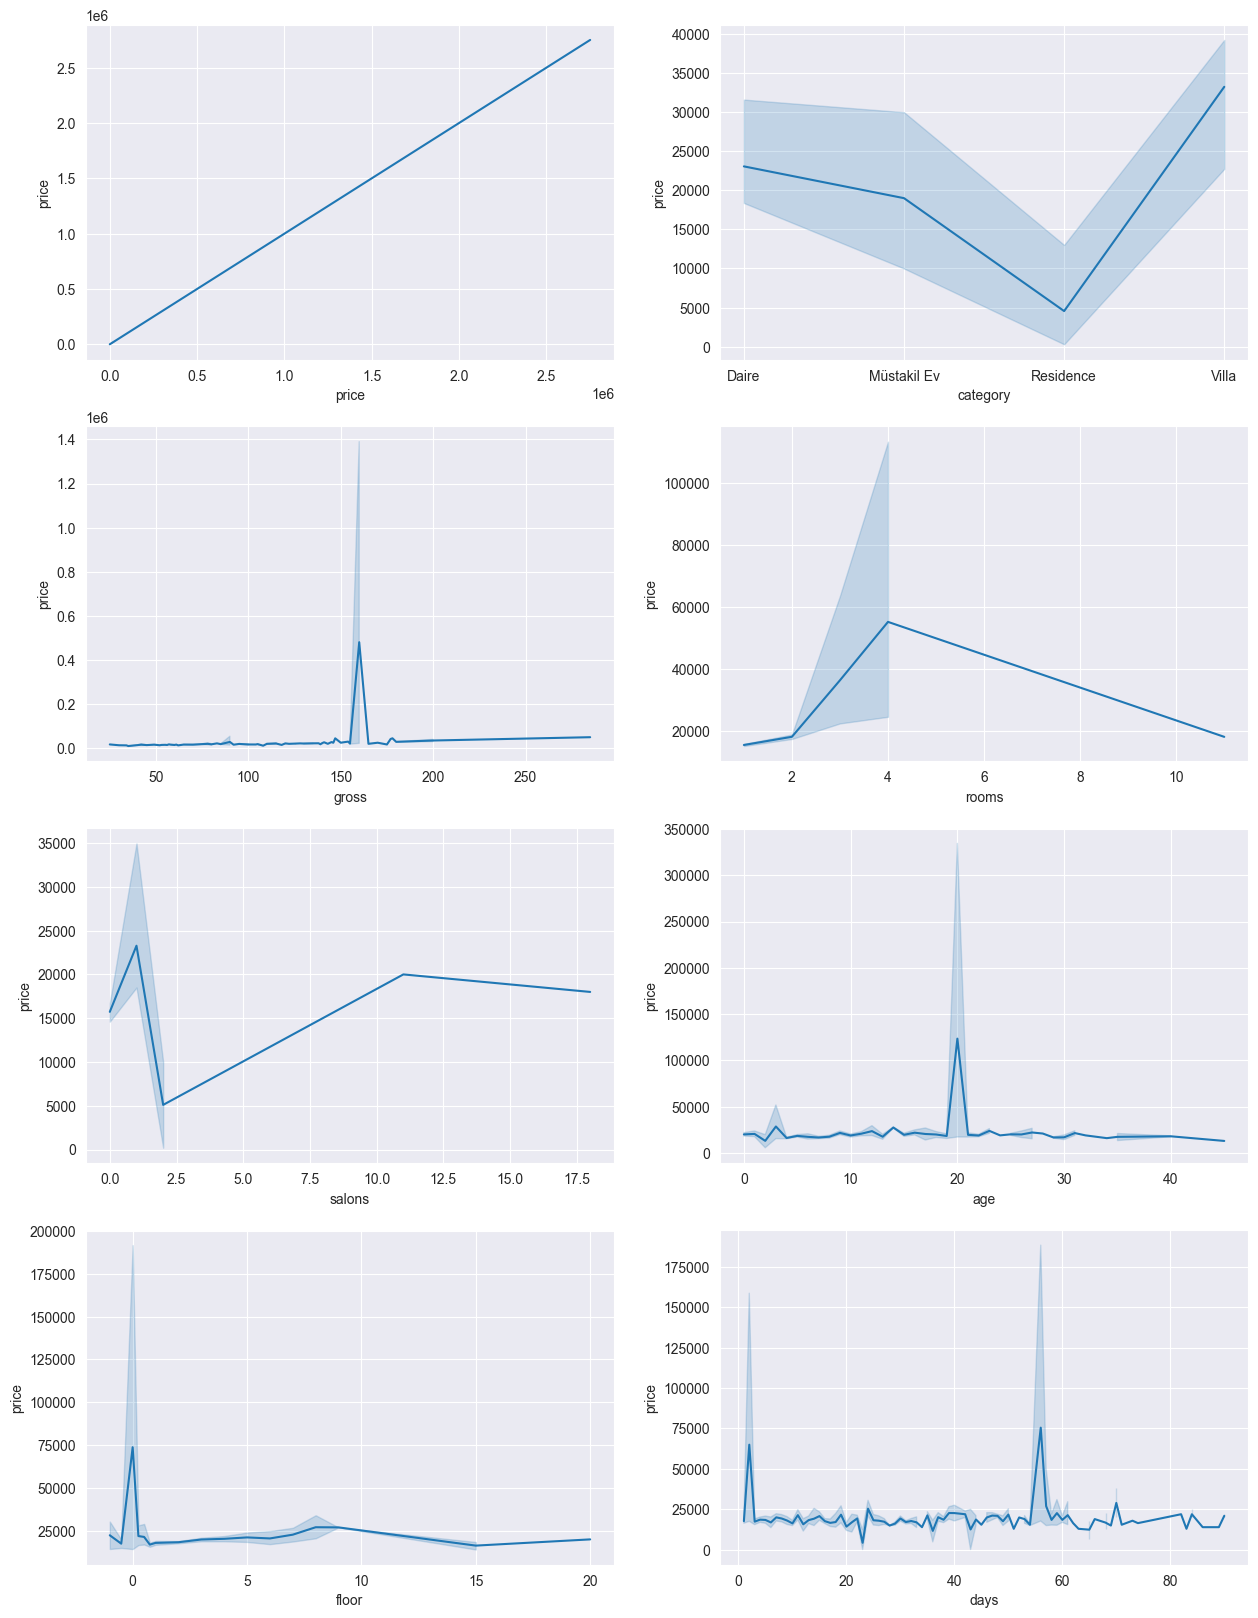

In [273]:
fig, axs = plt.subplots(4, 2, figsize = (15, 20))
        
for i in range(4):
    for j in range(2):
        sns.lineplot(x = df.iloc[:, i * 2 + j], y = df['price'], ax = axs[i, j])

In [274]:
px.bar(df.loc[df['rooms'] == 1, ['loc', 'price']], 'loc', 'price', 'loc')

In [275]:
px.bar(df.loc[df['rooms'] == 1, ['date', 'price']], 'date', 'price', 'date')

<Axes: >

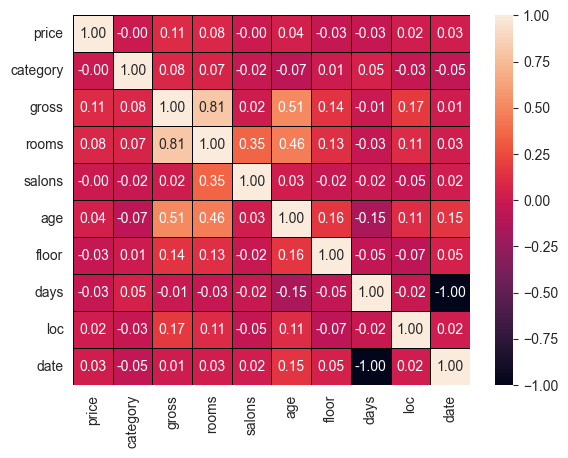

In [276]:
df['loc'] = le.fit_transform(df['loc'])
df['category'] = le.fit_transform(df['category'])

sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidths = 0.5, linecolor = 'black')

Feature importances

In [277]:
X = df.drop(columns = ['price', 'date'])
y = df['price']

importances = lgbm.fit(X, y).feature_importances_
features = df.drop(columns = ['price', 'date']).columns
px.bar(x = features, y = importances, labels = {'x': 'Features', 'y': 'Importances'}, color = importances)